In [113]:
import sys
import os
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('..')))

from utilities.plotting import LossPlotter

In [27]:
import time
import random
plotter = LossPlotter(smoothing=0.9)

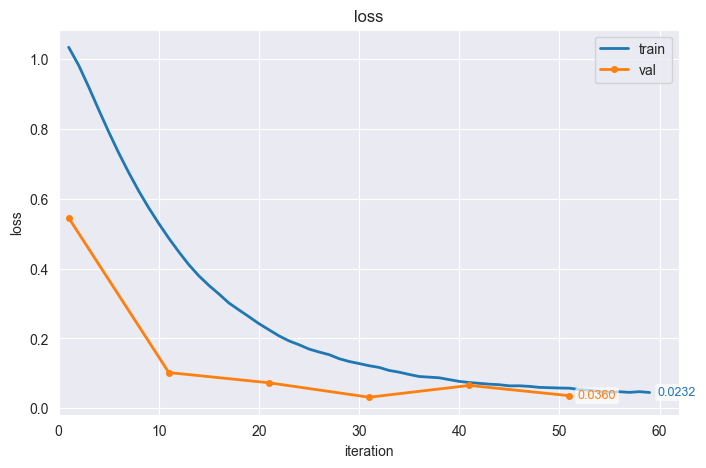

KeyboardInterrupt: 

In [28]:
print("running")
for i in range(100):
  train_loss = 1 / (i + 1) + random.uniform(0, 0.05)
  val_loss = 1 / (i + 2) + random.uniform(0, 0.05) if i % 10 == 0 else None
  plotter.update(train_loss, val_loss)
  time.sleep(0.05)

In [35]:
import math
import random

def generate_simulated_loss(iterations=5000):
    # Initialize lists to hold the loss values
    train_loss = []
    val_loss = []
    
    # Constants to control the shape of the curve
    # k_train and k_val control the decay rate (a larger denominator means slower decay)
    K_TRAIN_DECAY = 1200 
    K_VAL_DECAY = 850    
    
    # C_base is the asymptotic minimum loss
    C_TRAIN_BASE = 1.5
    C_VAL_BASE = 1.3
    
    # C_amp is the starting amplitude of the decay (i.e., the difference 
    # between starting loss and base loss)
    C_TRAIN_AMP = 3.5
    C_VAL_AMP = 3.2


    print(f"Simulating loss over {iterations} iterations...")

    # Loop through each iteration to calculate the loss
    for i in range(1, iterations + 1):
        
        # --- Train Loss Calculation ---
        
        # Exponential term: Decay from C_AMP down to 0
        exp_train = C_TRAIN_AMP * math.exp(-i / K_TRAIN_DECAY)
        
        # Random noise: A small, high-frequency fluctuation
        noise_train = random.uniform(-0.15, 0.15)
        
        # Total train loss: Base minimum + Exponential decay + Noise
        current_train_loss = C_TRAIN_BASE + exp_train + noise_train
        
        # Append the calculated loss (ensure it doesn't go below 1.0)
        train_loss.append(max(current_train_loss, 1.0))
        

        # --- Validation Loss Calculation ---
        
        # Exponential term: Decay term (designed to slightly faster/lower than train)
        exp_val = C_VAL_AMP * math.exp(-i / K_VAL_DECAY)
        
        # Random noise: Slightly smaller noise for a smoother val curve
        noise_val = random.uniform(-0.1, 0.1)
        
        # Total validation loss: Base minimum + Exponential decay + Noise
        current_val_loss = C_VAL_BASE + exp_val + noise_val
        
        # Append the calculated loss (ensure it doesn't go below 0.8)
        val_loss.append(max(current_val_loss, 0.8))


    print("Simulation complete. Data available in 'train_loss' and 'val_loss'.")
    return train_loss, val_loss

# Run the simulation
train_loss, val_loss = generate_simulated_loss(iterations=5000)

# Print a few samples to show the data structure
print("\n--- Sample Output (First 5 Iterations) ---")
for i in range(5):
    print(f"Iteration {i+1:4d}: Train Loss = {train_loss[i]:.4f}, Val Loss = {val_loss[i]:.4f}")
    
# Print the final values
print("\n--- Final Values ---")
print(f"Iteration 5000: Train Loss = {train_loss[-1]:.4f}, Val Loss = {val_loss[-1]:.4f}")


Simulating loss over 5000 iterations...
Simulation complete. Data available in 'train_loss' and 'val_loss'.

--- Sample Output (First 5 Iterations) ---
Iteration    1: Train Loss = 5.0986, Val Loss = 4.4544
Iteration    2: Train Loss = 5.0087, Val Loss = 4.4039
Iteration    3: Train Loss = 5.1117, Val Loss = 4.5696
Iteration    4: Train Loss = 5.0889, Val Loss = 4.5045
Iteration    5: Train Loss = 4.8661, Val Loss = 4.3850

--- Final Values ---
Iteration 5000: Train Loss = 1.5713, Val Loss = 1.3711


In [127]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import seaborn as sns

# 1. add simple train / loss functionality
# style next

class LossTracker:
  def __init__(self):
    sns.set_style("white")
    self.fig = plt.figure()
    #plt.close(self.fig)

    self.iter = []
    self.train = []
    self.val = []

    self.ax = self.fig.add_subplot(1, 1, 1)
    self.ax.set_xlim(0, 2500)
    self.ax.set_ylim(1, 5.25)
    self.train_line, = self.ax.plot(self.iter, self.train, 'r-', label='Train Loss')
    self.val_line, = self.ax.plot(self.iter, self.val, 'b--', label='Validation Loss')
    self.fig.canvas.draw_idle()
    self.ax_background = self.fig.canvas.copy_from_bbox(self.ax.bbox)
  
  def update(self, train: float, val: float = None, iteration: int = None) -> plt.Figure:
    current_iter = iteration or (self.iter[-1] + 1 if self.iter else 1)
    self.iter.append(current_iter)
    self.train.append(train)
    self.val.append(val)

    self.fig.canvas.restore_region(self.ax_background)
    self.train_line.set_data(self.iter, self.train)
    self.val_line.set_data(self.iter, self.val)

    xlim = self.ax.get_xlim()
    ylim = self.ax.get_ylim()
    if current_iter > xlim[1] or current_iter < xlim[0] or train > ylim[1] or train < ylim[0]:
      self.ax.relim()
      self.ax.autoscale_view()
      # If limits change, we must update the background and redraw everything
      self.fig.canvas.draw_idle()
      self.ax_background = self.fig.canvas.copy_from_bbox(self.ax.bbox)

    self.ax.draw_artist(self.train_line)
    self.ax.draw_artist(self.val_line)
    self.fig.canvas.blit(self.ax.bbox)
    return self.fig

In [128]:
lt = LossTracker()
import seaborn as sns
train_data, val_data = generate_simulated_loss()
val_data = [x*1.25 if i % 50 == 0 else None for i, x in enumerate(val_data)]

<IPython.core.display.Javascript object>

Simulating loss over 5000 iterations...
Simulation complete. Data available in 'train_loss' and 'val_loss'.


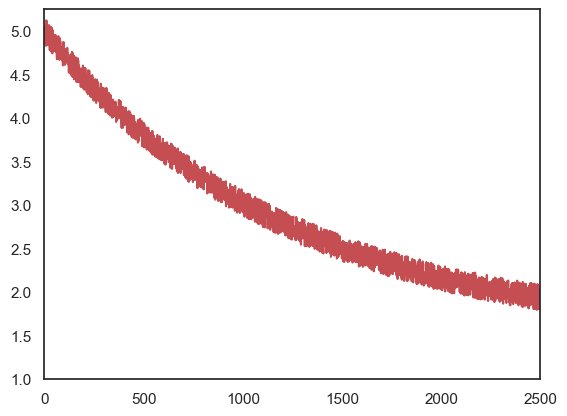

5000it [00:14, 352.97it/s]


In [129]:
i = 0
for t, v in tqdm(zip(train_data, val_data)):
  i += 1
  fig = lt.update(t, v)
  if i % 50 == 0:
    clear_output(wait=True)
    display(fig)

In [ ]:
plotter = LossPlotter(smoothing=0.9)

<IPython.core.display.Javascript object>

In [112]:
print("running")
for i in tqdm(range(5000)):
  train_loss, val_loss = train_data[i], val_data[i]
  plotter.update(train_loss, val_loss)

 26%|██▌       | 1311/5000 [00:57<02:41, 22.82it/s]


KeyboardInterrupt: 